In [1]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from comparers import ModelComparer, plot_decision_boundary
from diro2c_wrapper import WrappedDiro2C, plot_diro2c_2d, plot_diro2c_tree, \
                           print_diro2c_rules
from baseline import print_rules, plot_tree_leafs_for_class
from tasks.adult import make_task_with_influential_modification as make_task
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
clf_a, clf_b, X, X_display, y, feature_names = make_task()

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:36:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "nestimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:36:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:36:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "nestimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above c

In [3]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

# Local explanations

In [4]:
is_diff = comparer.predict_bin_diff(X)
mclass_diff = comparer.predict_mclass_diff(X)

## $(False, True)$

In [5]:
focus_class = '(False, True)'

In [15]:
explainer = WrappedDiro2C(X, comparer, focus_class)

Let's first check how long it takes to generate a data set for a single instance:

In [13]:
%%time
_ = explainer.generate_local_explanation(idx_explain=0)

CPU times: user 11min 29s, sys: 37.7 s, total: 12min 7s
Wall time: 3min 31s


In [14]:
((3*60 + 31) * len(X))/60/60

57.26305555555555

In [11]:
%%time
_ = explainer.generate_local_explanation(idx_explain=0, gn_population_size=500)

CPU times: user 1min 6s, sys: 4.77 s, total: 1min 11s
Wall time: 21 s


In [12]:
(21 * len(X))/60/60

5.699166666666667

Even with a reduced population size parameter it still would take more than 5 hours to generate data sets for all instances. I'll use a different approach, where the final data set is built from the merged generated data sets created for only the instances classified differently, but with the default population size parameter. This way, I expect the algorithm to generate instances near to the already known differences.

In [16]:
instance_indices = np.where(comparer.class_names[mclass_diff] == focus_class)[0]

In [17]:
%%time
explanations = []
for i, instance_idx in enumerate(instance_indices, 1):
    print(f'{i}/{len(instance_indices)}')
    explanation = explainer.generate_local_explanation(instance_idx)
    explanations.append(explanation)
with open(f'diro2c.{focus_class}.pickle', 'wb') as f:
    pickle.dump((explainer, explanations), f, pickle.HIGHEST_PROTOCOL)

1/14
2/14
3/14
4/14
5/14
6/14
7/14
8/14
9/14
10/14
11/14
12/14
13/14
14/14
CPU times: user 2h 34min 50s, sys: 10min 47s, total: 2h 45min 38s
Wall time: 52min 24s


In [18]:
with open(f'diro2c.{focus_class}.pickle', 'rb') as f:
    explainer, explanations = pickle.load(f)

In [19]:
class_names = explanations[0]['class_names']
feature_names = comparer.feature_names

In [20]:
X_explain = np.concatenate([explanation['binary_diff_classifer']['evaluation_info']['X']
                            for explanation in explanations])
y_explain = np.concatenate([explanation['binary_diff_classifer']['evaluation_info']['y']
                            for explanation in explanations])

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


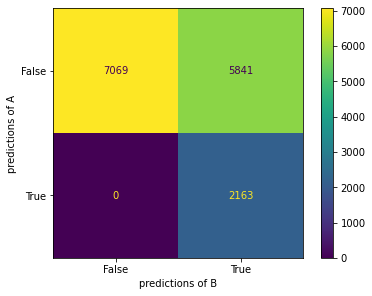

In [21]:
comparer.plot_confusion_matrix(X_explain)

In [23]:
# Check for errors
is_explain_diff = explainer.clf_a.predict(X_explain) != explainer.clf_b.predict(X_explain)
(is_explain_diff != y_explain).sum(), len(y_explain)

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


(0, 15073)

In [24]:
def explain(max_depth=None, tree_fig_size=(14, 14)):
    global tree
    tree = DecisionTreeClassifier(max_depth=max_depth)
    tree.fit(X_explain, y_explain)
    
    feature_importances = tree.feature_importances_
    feature_order = np.flip(np.argsort(feature_importances))
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.set_title('Relative feature importance')
    ax.scatter(np.flip(feature_importances[feature_order]),
               np.flip(comparer.feature_names[feature_order]))
    plt.show()
    
    fig, ax = plt.subplots(figsize=tree_fig_size)
    plot_tree(tree, feature_names=feature_names, class_names=class_names, ax=ax, node_ids=True, precision=1)
    
    y_test = mclass_diff == np.where(comparer.class_names == focus_class)[0][0]
    print_rules(tree, feature_names, class_names, focus_class, X_test=X, y_test=y_test, precision=1,
                feature_order=feature_order)
    
    plot_tree_leafs_for_class(tree, class_names, focus_class, X, mclass_diff, comparer.class_names,
                              feature_names)
    
    print('\ngenerated data evaluation:')
    print(classification_report(y_explain, tree.predict(X_explain), target_names=class_names))

    print('\noriginal data evaluation:')
    print(classification_report(mclass_diff == np.where(comparer.class_names == focus_class)[0][0],
                                tree.predict(X), target_names=class_names))

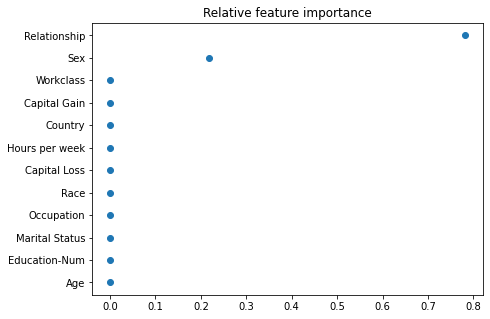

node #11: if (Relationship > 3.6) and (Relationship <= 4.5) and (Sex > 0.8) then class (False, True) (covers 0.736 of 5786 instances)
node #9: if (Relationship > 4.9) and (Sex <= 0.8) then class (False, True) (covers 0.577 of 2011 instances)
node #2: if (Relationship <= 3.6) and (Workclass <= -0.5) then class (False, True) (covers 1.0 of 1 instances)

generated data evaluation:
                   precision    recall  f1-score   support

not (False, True)       0.94      0.74      0.83      9232
    (False, True)       0.69      0.93      0.79      5841

         accuracy                           0.81     15073
        macro avg       0.82      0.83      0.81     15073
     weighted avg       0.85      0.81      0.82     15073


original data evaluation:
                   precision    recall  f1-score   support

not (False, True)       1.00      0.57      0.73       963
    (False, True)       0.03      1.00      0.06        14

         accuracy                           0.58       9

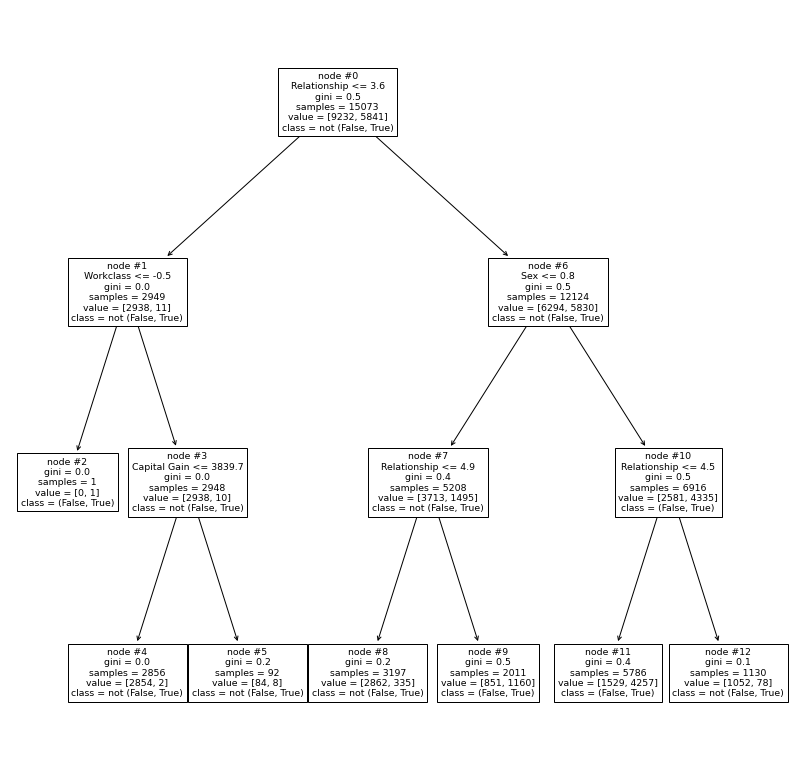

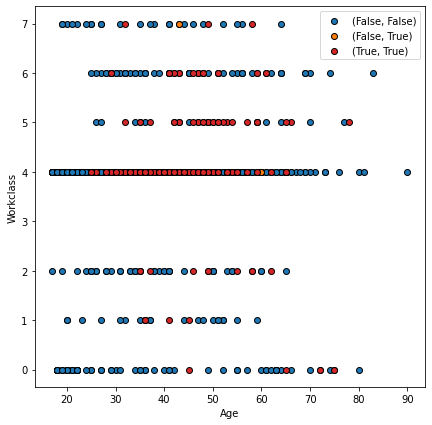

In [25]:
explain(max_depth=3)

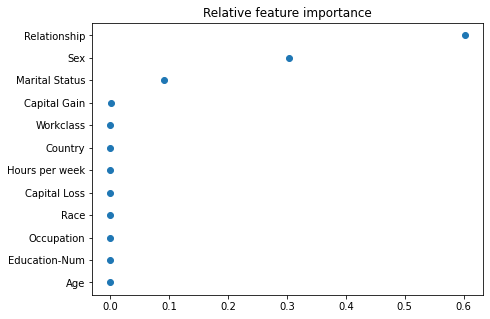

node #20: if (Relationship > 3.6) and (Relationship <= 4.5) and (Sex > 0.8) and (Marital Status <= 2.5) then class (False, True) (covers 0.796 of 5191 instances)
node #16: if (Relationship > 4.9) and (Sex <= 0.4) then class (False, True) (covers 0.836 of 1307 instances)
node #24: if (Relationship > 4.5) and (Sex > 0.8) and (Marital Status > 4.5) then class (False, True) (covers 0.6 of 10 instances)
node #2: if (Relationship <= 3.6) and (Workclass <= -0.5) then class (False, True) (covers 1.0 of 1 instances)

generated data evaluation:
                   precision    recall  f1-score   support

not (False, True)       0.93      0.86      0.89      9232
    (False, True)       0.80      0.90      0.85      5841

         accuracy                           0.88     15073
        macro avg       0.87      0.88      0.87     15073
     weighted avg       0.88      0.88      0.88     15073


original data evaluation:
                   precision    recall  f1-score   support

not (False, Tru

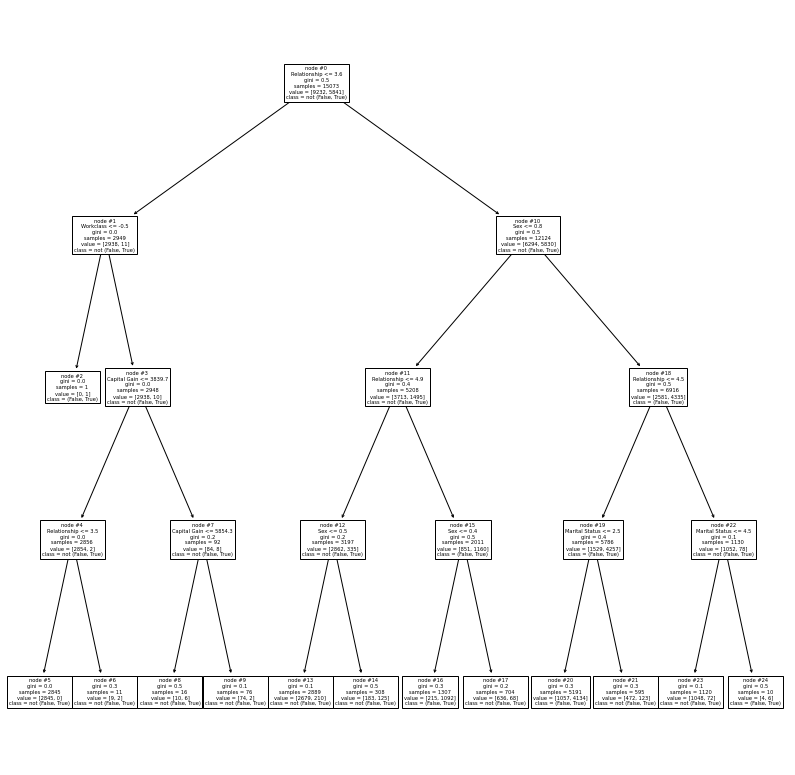

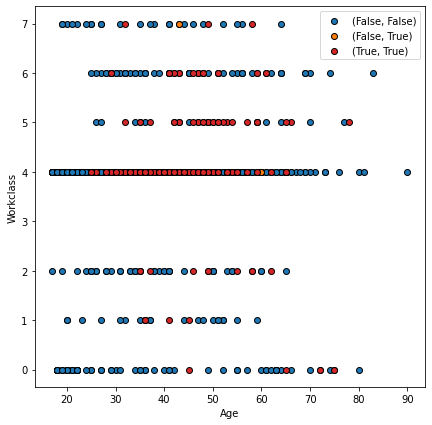

In [26]:
explain(max_depth=4)

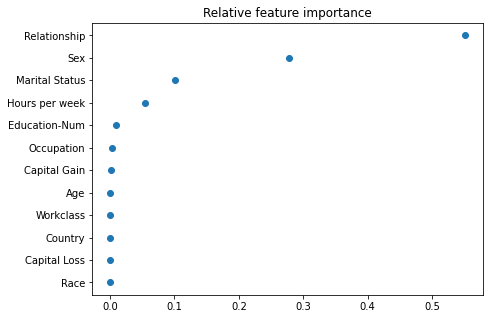

node #36: if (Relationship > 3.6) and (Relationship <= 4.5) and (Sex > 0.8) and (Marital Status <= 2.5) and (Hours per week > 39.5) then class (False, True) (covers 0.824 of 5010 instances)
node #28: if (Relationship > 4.9) and (Sex <= 0.4) and (Education-Num > 10.3) then class (False, True) (covers 0.858 of 1264 instances)
node #31: if (Relationship > 4.9) and (Sex > 0.4) and (Sex <= 0.8) and (Marital Status > 2.5) then class (False, True) (covers 0.521 of 73 instances)
node #12: if (Relationship <= 3.6) and (Capital Gain > 3839.7) and (Capital Gain <= 5854.3) and (Age > 45.0) and (Workclass > -0.5) then class (False, True) (covers 0.8 of 5 instances)
node #46: if (Relationship > 4.5) and (Sex > 0.8) and (Marital Status > 4.5) and (Education-Num > 12.6) then class (False, True) (covers 1.0 of 4 instances)
node #7: if (Relationship > 3.5) and (Relationship <= 3.5) and (Capital Gain <= 3839.7) and (Workclass > -0.5) then class (False, True) (covers 0.667 of 3 instances)
node #14: if (Re

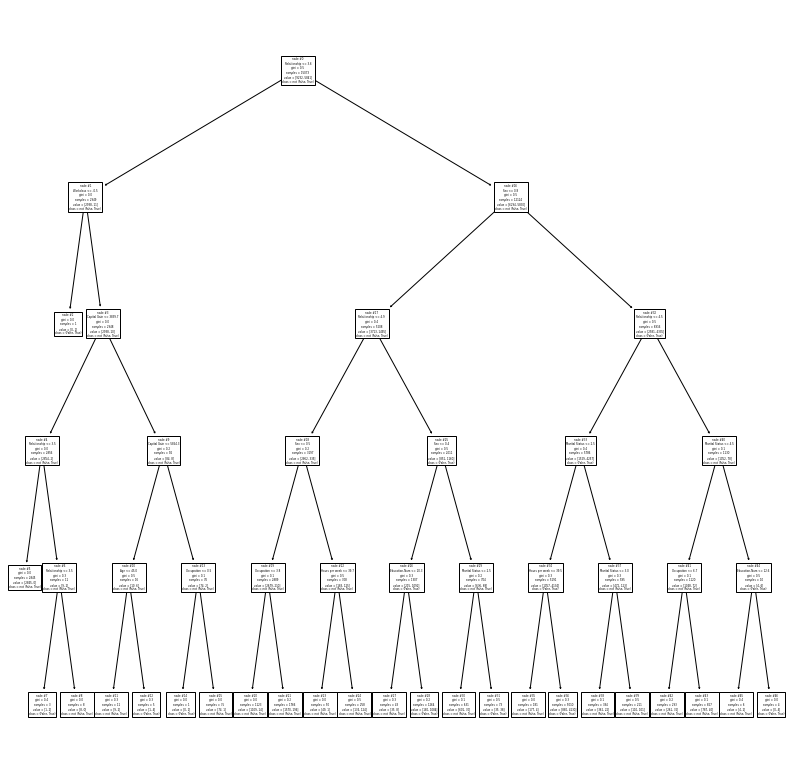

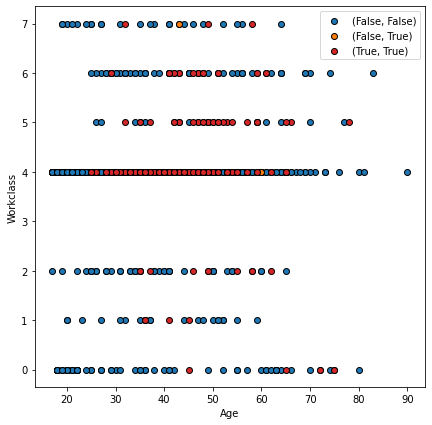

In [27]:
explain(max_depth=5)

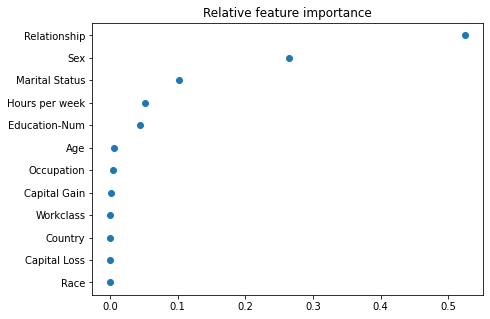

node #64: if (Relationship > 3.6) and (Relationship <= 4.5) and (Sex > 0.8) and (Marital Status <= 2.5) and (Hours per week > 39.5) and (Education-Num > 10.8) then class (False, True) (covers 0.905 of 3273 instances)
node #63: if (Relationship > 3.6) and (Relationship <= 4.5) and (Sex > 0.8) and (Marital Status <= 2.5) and (Hours per week > 39.5) and (Education-Num <= 10.8) then class (False, True) (covers 0.672 of 1737 instances)
node #47: if (Relationship > 4.9) and (Sex <= 0.4) and (Marital Status <= 2.5) and (Education-Num > 10.3) then class (False, True) (covers 0.884 of 1184 instances)
node #40: if (Relationship > 3.6) and (Relationship <= 4.9) and (Sex > 0.5) and (Sex <= 0.8) and (Hours per week > 39.7) and (Education-Num > 10.9) then class (False, True) (covers 0.617 of 162 instances)
node #71: if (Relationship > 3.6) and (Relationship <= 4.5) and (Sex > 0.8) and (Marital Status > 3.0) and (Education-Num > 10.8) then class (False, True) (covers 0.596 of 141 instances)
node #54:

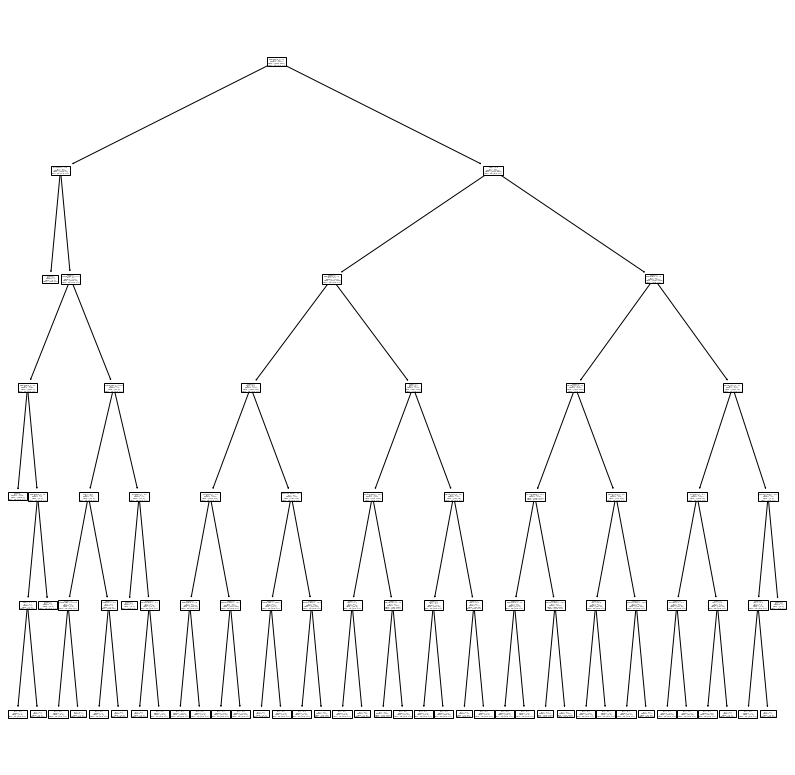

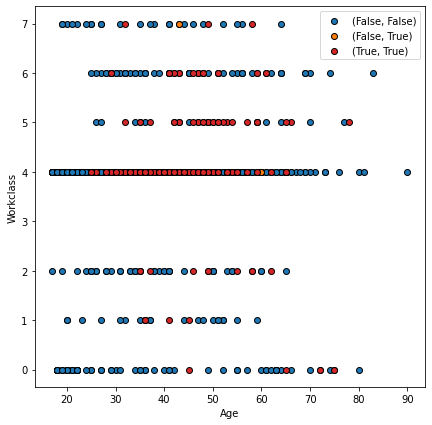

In [31]:
explain(max_depth=6)